In [102]:
from modules.random_forest import test
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from modules.utils import load_dataset, split_dataset_train_test
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn import PermutationImportance
from sklearn.tree import export_graphviz
from sklearn.cluster import Birch
from scipy.stats import entropy
from sklearn.metrics import r2_score, mean_squared_error, recall_score, precision_score, confusion_matrix
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [104]:
X,y= load_dataset('data/test_sample.csv')

In [105]:
X_tr, Xt, y_tr, yt = train_test_split(X, y, test_size=0.2)

In [107]:
clf = RandomForestClassifier().fit(X_tr, y_tr)

In [109]:
y_pred = clf.predict(Xt)
matrix, scores_ensemble_dmi, ruo_curve_val = test(yt, y_pred)

In [111]:
view_scores = pd.DataFrame(scores_ensemble_dmi, index=[0])
view_scores

,precision,error,f1-score,recall,accuracy,roc_auc_score
0,0.373626,0.359,0.159251,0.10119,0.641,0.507674


#### Refaire donnée experience perdu

In [80]:
split_dataset_train_test(0.2, shuffle=True, do_flat=False)

c:\Users\Auguste Tiemele\Documents\Projet Maitrise I.A Ulaval\Session 4\Analyse et traitement de données massives\Projet\drug-harmful-combination\modules\utils.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test_hospit.append(df_test_no_hospit)


done!


('data/train_set.csv', 'data/test_set.csv')

In [81]:
X_train, y_train = load_dataset('data/train_set.csv', is_order=True)
X_test, y_test = load_dataset('data/test_set.csv', is_order=True)

In [82]:
print(f'Nombres observation en entrainement: {len(X_train)}')
print(f'Nombres observation en test: {len(X_test)}')

Nombres observation en entrainement: 1299915
Nombres observation en test: 120894


Après avoir utilisé le jeu de données tel quel, nous avons obtenu des résultats médiocres avec notre modèle Random Forest. En analysant les différents scores AUC, nous avons remarqué que notre algorithme avait du mal à classer correctement les données, ce qui nous a conduit à nous poser des questions sur la représentativité des données. Dans notre problème, nous avons une liste de médicaments représentant les attributes qui prennent comme valeur {0, 1}. Intuitivement, si les données sont bruyantes, nous obtiendrons un problème similaire à XOR, mais cette fois avec 18 dimensions au lieu de 2, ce qui rendra le problème trop complexe pour des approches de machine learning classique. Pour le problème de XOR, il est possible de modifier sa représentation pour le discriminer. Dans notre cas, chaque observation correspond à la prescription d'un client et si ce client a été hospitalisé ou non. Nous allons donc essayer de changer le problème en considérant le nombre de fois que chaque médicament a été prescrit pour déterminer si le client a été au moins un fois hospitalisé ou non (0, 1). Cette représentation nous permet de discriminer si le client a été hospitalisé ou non. Cependant, cette représentation ajoute un biais qui est la fréquence d'utilisation des médicaments.

In [83]:
pd.DataFrame(X_train, columns=[f'drug_{x}' for x in range(19)])

,drug_0,drug_1,drug_2,drug_3,drug_4,drug_5,drug_6,drug_7,drug_8,drug_9,drug_10,drug_11,drug_12,drug_13,drug_14,drug_15,drug_16,drug_17,drug_18
0,5,0,0,2,3,0,0,0,0,5,0,0,0,2,5,5,0,0,0
1,3,0,0,1,0,1,5,0,5,5,0,2,0,0,4,5,0,0,0
2,11,15,11,5,15,12,13,11,0,1,0,3,15,2,0,0,15,5,4
3,1,3,0,0,3,3,0,3,0,3,0,0,0,0,0,0,0,0,0
4,2,0,8,6,8,0,0,3,6,2,0,5,0,8,0,5,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299910,17,17,11,17,5,11,2,13,14,10,6,12,8,0,15,16,15,14,10
1299911,7,3,0,4,0,2,4,0,0,0,7,0,0,0,7,7,0,1,7
1299912,9,7,4,6,11,14,14,14,11,5,6,10,2,0,14,0,0,2,8
1299913,0,0,1,0,0,0,0,0,0,3,3,3,0,0,0,3,3,0,0


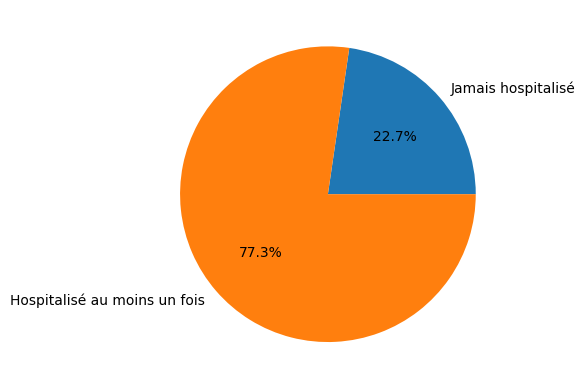

In [87]:
y = np.append(y_train,y_test)
y = np.where(y>=1, 1, 0)
hospit = np.bincount(y)
plt.pie(hospit, labels=['Jamais hospitalisé','Hospitalisé au moins un fois'], autopct='%1.1f%%');

Nous remaquons qu'il a sur les 3 millions de patients 22.7% qui on u des prescription de de medicament mais non jamais été hospitalisé. Cette donnée peu nous prete a dire qu'il y a des prescription de medicament qui influance tres peu le fait d'etre hospitalise ou pas. Mais ce qui n'annule pas le fait que l'on peut avoir un biais sur la frequence d'utilisation d'un patient.

Pour notre algorithme, nous utiliserons encore Random Forest avec des parametre de suivant, nombre d'arbre 100 pour commencer, nombre d'attributs par arbres sqrt(18) equivalent a 4 attributs par arbres. Et aussi comme nos donnee son inbalance, nous allons les balancer ajoutants un poids sur les instances avec L'algo de random forest  (n_samples / (n_classes * [n_hospit, no_hospit])).

In [89]:
random_clf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
print(f'Exactitude(R2_score) {random_clf.score(X_train, y_train)}')

Exactitude(R2_score) 0.9440897034037727


In [91]:
y_pred = random_clf.predict(X_test)
scores_ensemble = {
    'R2_carre': r2_score(y_test, y_pred),
    'Mean_sqart': mean_squared_error(y_test, y_pred)
}

In [90]:
y_pred = random_clf.predict(X_test)
matrix, scores_ensemble, ruo_curve_val = test(y_test, y_pred)

fig, ax = plt.subplots()
ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuel', fontsize=12)
plt.title('Matrix de confusion', fontsize=12);

ValueError: Classification metrics can't handle a mix of binary and continuous targets

####  Test Resultat 

In [92]:
view_scores = pd.DataFrame(scores_ensemble, index=[0])
view_scores

,R2_carre,Mean_sqart
0,-3.865617,1.211008


Nous avons un score parfait en test. Aucune erreur et un classifieur parfait. Je tient a precise que les données en test non jamais ete vu par notre modele

In [11]:
export_graphviz(random_clf.estimators_[99], out_file='tree.dot', feature_names=[f'drug_{x}' for x in range(19)], class_names=['Jamais Hospitalisé', 'Hospitalisé au moins un fois'], rounded=True, proportion=False, precision=2, filled=True)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png', width=1000, height=1000)

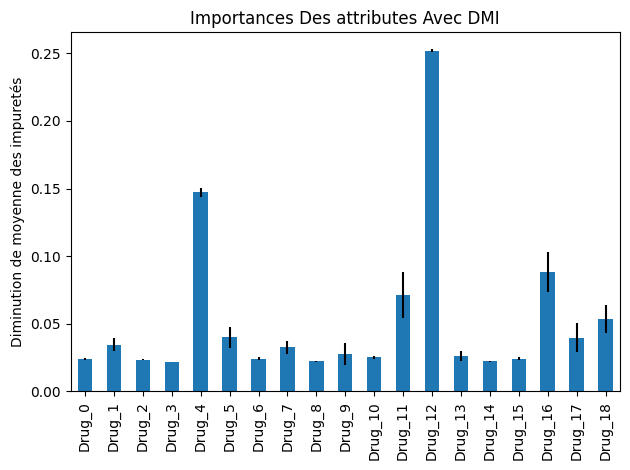

In [93]:
feature_names = np.array([f'Drug_{x}' for x in range(19)])
importances = random_clf.feature_importances_
importances_std = np.std([tree.feature_importances_ for tree in random_clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances_std, ax=ax)
ax.set_title("Importances Des attributes Avec DMI")
ax.set_ylabel("Diminution de moyenne des impuretés")
fig.tight_layout()


Nous utilisons l'importance des attributs dans le graphique ci-dessus, qui est calculée en trouvant la moyenne des diminutions d'impureté. La formule de diminution de l'impureté est la suivante : [insérez ici la formule]. Cette mesure est fortement biaisée par la cardinalité des attributs. Cependant, essayons de récupérer les attributs importants pour notre classification avec cette mesure.

In [94]:
selection_importance = SelectFromModel(random_clf).fit(X_test, y_test)

X_train_from_mdi = selection_importance.transform(X_train)
X_test_from_mdi = selection_importance.transform(X_test)

label_select = feature_names[selection_importance.get_support()] 

print(f'Selection Par DMI {label_select}')

Selection Par DMI ['Drug_0' 'Drug_1' 'Drug_6' 'Drug_7' 'Drug_9' 'Drug_10' 'Drug_11'
 'Drug_12' 'Drug_13' 'Drug_17' 'Drug_18']


En utilisant la mesure d'importance, nous avons obtenu la combinaison suivante : (4, 5, 11, 12, 16, 17).

Text(0, 0.5, 'Nb de presciptions')

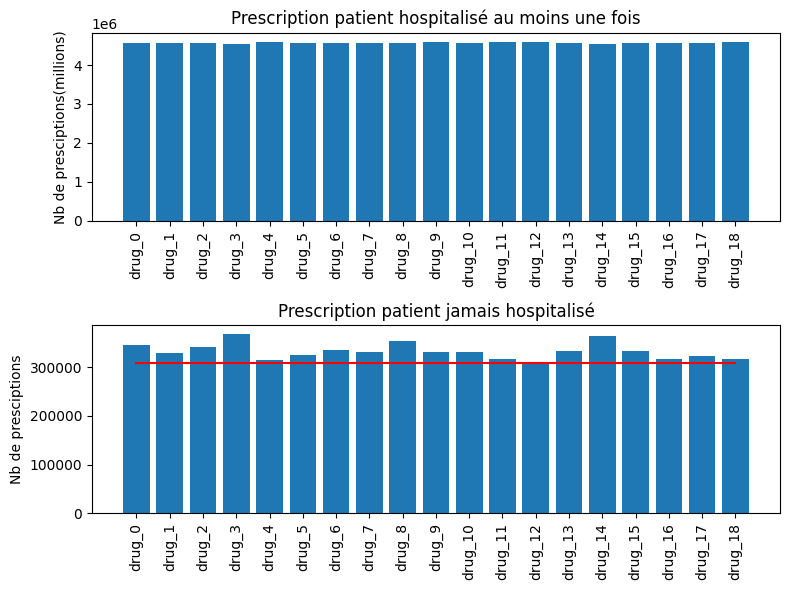

In [14]:
fig, (ax1, ax2)= plt.subplots(2, 1, tight_layout=True, figsize=(8, 6))

X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test)

idx_no_hospit = np.argwhere(y == 0)
bins_no_hospit = np.sum(X[idx_no_hospit], axis=0)[0]

idx_hospit = np.argwhere(y == 1)
bins_hospit = np.sum(X[idx_hospit], axis=0)[0]

ax1.bar(x=[f'drug_{x}' for x in range(len(bins_hospit))], height=bins_hospit)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title('Prescription patient hospitalisé au moins une fois')
ax1.set_ylabel('Nb de presciptions(millions)')

ax2.bar(x=[f'drug_{x}' for x in range(len(bins_no_hospit))], height=bins_no_hospit)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.plot(np.arange(0, len(bins_no_hospit),1), [bins_no_hospit[12] for x in range(len(bins_no_hospit))], color='red', label='drug_12')

ax2.set_title('Prescription patient jamais hospitalisé')
ax2.set_ylabel('Nb de presciptions')

Les 19 medicament on ete au moins une fois prescrit a tous les persons qui on ete une fois hospitalise.
Le medicament avec de grande feature importance on ete eux aussi prescrit au patient qui on n'on jamais ete hospitalise.
idee a explorer:

1- peut etre que ce sont des medicaments que l'on prescrit rarement a des personne a faible risque et en polypharmacie. Alors combine ces medicament avec d'autre medicament peut etre dangereux. Nous allons donc ...

2- peut etre que le fait que c'est medicament soit tres peu utilise chez les patients en poly et en bonne sante, nous dit que ces medicament sont bien documenté et leurs prescritpions est fait avec precossion donc essayons d'enlever ses medicament de nos données pour voir comment ca affectera nos decission.

Rappelons que notre algorithme a trouvé les médicaments suivants : ['Drug_4', 'Drug_5', 'Drug_11', 'Drug_12', 'Drug_16', 'Drug_17', 'Drug_18']. Le graphique ci-dessus représente le nombre d'apparitions ou d'utilisation des médicaments. Nous observons que le nombre d'utilisation des médicaments pour les clients qui ont été au moins une fois hospitalisés est identique, tandis que le nombre d'apparitions des médicaments chez les clients qui n'ont jamais été hospitalisés est distribué différemment. Nous constatons également que les médicaments les moins utilisés chez les clients qui n'ont jamais été hospitalisés sont ceux qui sont prescrits le moins souvent par rapport aux autres, et qui sont présents dans les prescriptions des personnes hospitalisées. Comme prévu, l'algorithme accorde donc plus d'importance aux médicaments qui ont été peu utilisés chez les clients qui n'ont jamais été hospitalisés et qui ont utilisé ces médicaments moins fréquemment que les clients qui ont été hospitalisés au moins une fois.

Cependant, cela ne nous dit en rien si l'utilisation de ces 7 médicaments en combinaison est néfaste. Pour ajuster notre résultat, nous pouvons essayer deux méthodes différentes. La première consiste à vérifier si notre algorithme réussit toujours à bien classer les données en n'utilisant que ces 7 médicaments, puis à ajouter des poids à ces attributs et à refaire un entraînement. Ensuite, nous regardons l'importance des attributs et nous sélectionnons les attributs importants restants. La seconde méthode consiste à faire une permutation des attributs en utilisant leur importance et à garder ceux qui prédisent le mieux notre jeu de données en utilisant le score de précision.

In [15]:
random_clf_dmi = RandomForestClassifier(random_state=42,  class_weight='balanced').fit(X_train_from_mdi, y_train)
print(f'Exactitude {random_clf_dmi.score(X_train_from_mdi, y_train)}')

Exactitude 0.8188350141512464


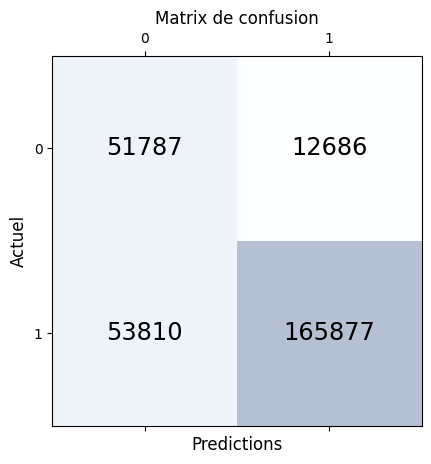

In [16]:
y_pred = random_clf_dmi.predict(X_test_from_mdi)
matrix, scores_ensemble_dmi, ruo_curve_val = test(y_test, y_pred)

fig, ax = plt.subplots()
ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuel', fontsize=12)
plt.title('Matrix de confusion', fontsize=12);

In [17]:
view_scores = pd.DataFrame(scores_ensemble_dmi, index=[0])
view_scores

,precision,error,f1-score,recall,accuracy,roc_auc_score
0,0.928955,0.234009,0.83303,0.755061,0.765991,0.779148


Nous obtenons toujours un score parfait en utilisant uniquement ces 7 médicaments sélectionnés.

In [18]:
headers = ['patient_id', 'timestamp']
headers  += [f'drug_{x}' for x in range(19)]
headers.append('hospit')
patient_with_combi = pd.read_csv('data/resultat_first_combi_random.csv', sep=';', names=headers)
patient_with_combi

,patient_id,timestamp,drug_0,drug_1,drug_2,drug_3,drug_4,drug_5,drug_6,drug_7,drug_8,drug_9,drug_10,drug_11,drug_12,drug_13,drug_14,drug_15,drug_16,drug_17,drug_18,hospit
0,1011667,2007-04-19,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0
1,1011667,2007-04-28,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1
2,1132106,2005-09-27,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0
3,1409243,2003-04-02,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0
4,1409243,2003-05-28,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1
5,1717473,2007-12-05,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1
6,1827310,2005-08-17,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1
7,1860542,2012-09-13,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0
8,1868594,2019-11-06,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1
9,2121409,2015-12-03,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1


Nous pouvons observer qu'il y a 24 observation qui on cette combinaisons sur les 30millions d'oberservation et sur ces 24 observation nous avons 15 observation qui donne une hospitalisation c'est a dire 60% des observation retenu.

In [19]:
patient_with_combi_by_pt = patient_with_combi.groupby('patient_id', group_keys=True).apply(lambda x: x)
patient_with_combi_by_pt

patient_id   timestamp  drug_0  ...  drug_17  drug_18  hospit
patient_id                                     ...                          
231592     10      231592  2015-01-10       0  ...        1        1       0
           11      231592  2014-05-25       0  ...        1        1       0
362381     15      362381  2015-10-25       0  ...        1        1       1
           16      362381  2014-05-10       0  ...        1        1       1
639287     17      639287  2021-04-09       0  ...        1        1       1
653506     18      653506  2004-05-10       0  ...        1        1       1
           19      653506  2004-06-11       0  ...        1        1       1
           20      653506  2004-07-05       0  ...        1        1       1
           21      653506  2004-07-18       0  ...        1        1       0
691339     22      691339  2002-07-19       0  ...        1        1       0
938810     23      938810  2005-07-16       0  ...        1        1       0
962825     24      962825  2013-10-20       0  ...        1        1       1
1011667    0      1011667  2007-04-19       0  ...        1        1       0
           1      1011667  2007-04-28       0  ...        1        1       1
1132106    2      1132106  2005-09-27       0  ...        1        1       0
1409243    3      1409243  2003-04-02       0  ...        1        1       0
           4      1409243  2003-05-28       0  ...        1        1       1
1717473    5      1717473  2007-12-05       0  ...        1        1       1
1827310    6      1827310  2005-08-17       0  ...        1        1       1
1860542    7      1860542  2012-09-13       0  ...        1        1       0
1868594    8      1868594  2019-11-06       0  ...        1        1       1
2121409    9      2121409  2015-12-03       0  ...        1        1       1
2580701    12     2580701  2007-07-21       0  ...        1        1       1
           13     2580701  2007-09-14       0  ...        1        1       1
           14     2580701  2007-09-28       0  ...        1        1       0

[25 rows x 22 columns]

Mais lorsque l'on regroupe nos resultats par patients nous pouvons observer que sur les nos 25 observations nous avons 16 patients et sur ses 16 patients nous avons 10 patients a qui on a prescrit notre comibaison et on ete hospitalise, soit 62.5% de nos patient observé ici. 

In [20]:
patient_with_combi_by_pt.sort_values(by=['timestamp'])

patient_id   timestamp  drug_0  ...  drug_17  drug_18  hospit
patient_id                                     ...                          
691339     22      691339  2002-07-19       0  ...        1        1       0
1409243    3      1409243  2003-04-02       0  ...        1        1       0
           4      1409243  2003-05-28       0  ...        1        1       1
653506     18      653506  2004-05-10       0  ...        1        1       1
           19      653506  2004-06-11       0  ...        1        1       1
           20      653506  2004-07-05       0  ...        1        1       1
           21      653506  2004-07-18       0  ...        1        1       0
938810     23      938810  2005-07-16       0  ...        1        1       0
1827310    6      1827310  2005-08-17       0  ...        1        1       1
1132106    2      1132106  2005-09-27       0  ...        1        1       0
1011667    0      1011667  2007-04-19       0  ...        1        1       0
           1      1011667  2007-04-28       0  ...        1        1       1
2580701    12     2580701  2007-07-21       0  ...        1        1       1
           13     2580701  2007-09-14       0  ...        1        1       1
           14     2580701  2007-09-28       0  ...        1        1       0
1717473    5      1717473  2007-12-05       0  ...        1        1       1
1860542    7      1860542  2012-09-13       0  ...        1        1       0
962825     24      962825  2013-10-20       0  ...        1        1       1
362381     16      362381  2014-05-10       0  ...        1        1       1
231592     11      231592  2014-05-25       0  ...        1        1       0
           10      231592  2015-01-10       0  ...        1        1       0
362381     15      362381  2015-10-25       0  ...        1        1       1
2121409    9      2121409  2015-12-03       0  ...        1        1       1
1868594    8      1868594  2019-11-06       0  ...        1        1       1
639287     17      639287  2021-04-09       0  ...        1        1       1

[25 rows x 22 columns]

En ajoutant des poids pour essayer de forcer une régularité dans nos distributions de médicaments, nous observons que notre prédiction sur l'ensemble de test avec des instances sans poids est complètement catastrophique, avec une précision de 0. Il est évident qu'en forçant une égalité entre les features, cela biaise totalement le calcul de nos statistiques pour pouvoir effectuer la prédiction.

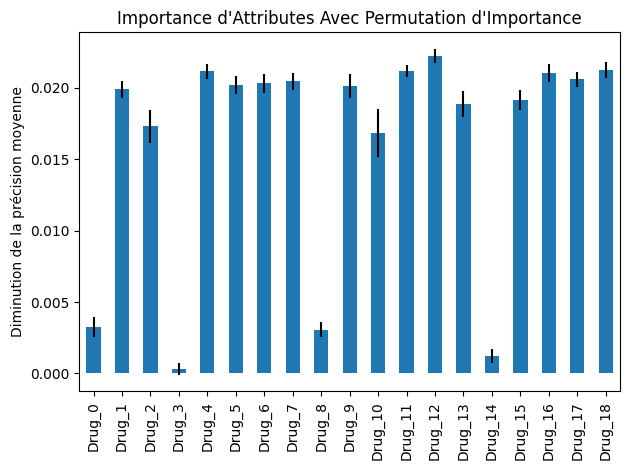

In [29]:
perm = PermutationImportance(RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1), random_state=42, cv=5)
perm.fit(X_train, y_train)

selection_importance_DPM = SelectFromModel(
    perm
).fit(X_test, y_test)

feature_names = np.array([f'Drug_{x}' for x in range(19)])
importances_pt = pd.Series(perm.feature_importances_ , index=feature_names)

fig, ax = plt.subplots()
importances_pt.plot.bar(yerr=perm.feature_importances_std_, ax=ax)
ax.set_title("Importance d'Attributes Avec Permutation d'Importance")
ax.set_ylabel("Diminution de la précision moyenne")
fig.tight_layout()
plt.show()

In [31]:
label_select = feature_names[selection_importance_DPM.get_support()] 

print(f'treshold: {selection_importance.threshold_}')
print(f'Selection Par DPM {label_select}')

treshold: 0.05263157894736842
Selection Par DPM ['Drug_1' 'Drug_4' 'Drug_5' 'Drug_6' 'Drug_7' 'Drug_9' 'Drug_10' 'Drug_11'
 'Drug_12' 'Drug_13' 'Drug_15' 'Drug_16' 'Drug_17' 'Drug_18']


In [32]:
X_train_from_dpm = selection_importance_DPM.transform(X_train)
X_test_from_dpm = selection_importance_DPM.transform(X_test)

In [33]:
random_clf_dpm = RandomForestClassifier(random_state=42, class_weight='balanced').fit(X_train_from_dpm, y_train)
print(f'Exactitude {random_clf_dpm.score(X_train_from_dpm, y_train)}')

Exactitude 0.9318769470610541


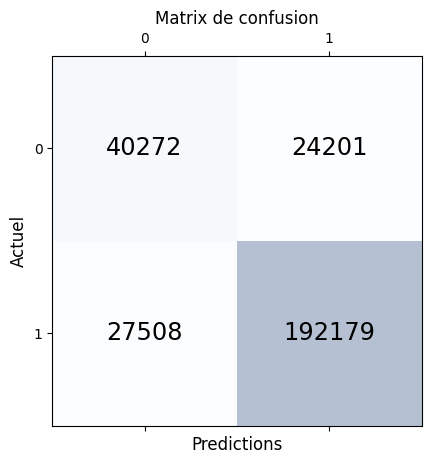

In [34]:
y_pred = random_clf_dpm.predict(X_test_from_dpm)
matrix, scores_ensemble_dmp, ruo_curve_val = test(y_test, y_pred)

fig, ax = plt.subplots()
ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuel', fontsize=12)
plt.title('Matrix de confusion', fontsize=12);

In [35]:
view_scores = pd.DataFrame(scores_ensemble_dmp, index=[0])
view_scores

,precision,error,f1-score,recall,accuracy,roc_auc_score
0,0.888155,0.181971,0.88142,0.874785,0.818029,0.74971


### Travail sur recuperation des combinaisons avec idée 1
Peut etre que ce sont des medicaments que l'on prescrit rarement a des personne a faible risque et en polypharmacie. Alors combiner ces medicaments avec d'autre medicament peut etre dangereux. Nous allons donc essaye dans un priemier d'analyse les statistique de nos donnéé avec les personnes a qui on a prescrit les drugs: 4, 11, 12, 16, 17, 18. Ensuite nous allons modifier notre dataset pour avoir le nombre de prescrit des autres medicaments sauf les drugs detecter pour entrainer un medicent.

Nous allons faire une regression pour voir comment nos donnee restant son separer puis avec le feature importance nous allons selection nos medicament qui influence le plus la seperation des donnée  pour finalise nos data

In [99]:
df_method1 = pd.read_csv('data/data_poly_only_method_1.csv', delimiter=';')

num_observation = df_method1.shape[0]
num_hospit = df_method1[df_method1['hospit'] == 1].shape[0]
num_no_hospit = df_method1[df_method1['hospit'] == 0].shape[0]

In [100]:
df_method1.shape[0]

25990

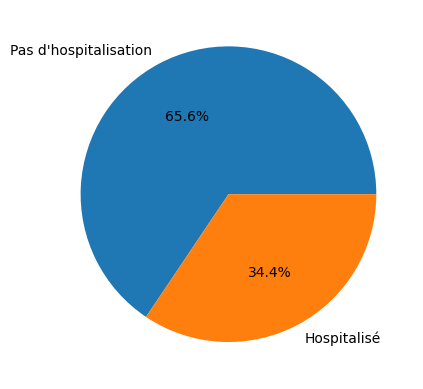

In [37]:
prob = [num_no_hospit, num_hospit]
plt.pie(prob, labels=['Pas d\'hospitalisation','Hospitalisé'], autopct='%1.1f%%');

Nous observons que nous avons des observations de 50% de chaque cote d'hospit et de non hospit avec comme base de prescription de medicament 4, 11, 12, 16, 17, 18.
Essayons de voir ce graphe par patient

In [38]:
group_patient = df_method1.groupby('patient_id').count()
num_patient = group_patient.shape[0]

<BarContainer object of 2 artists>

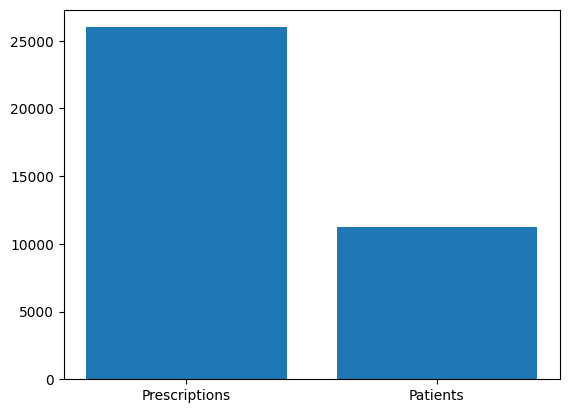

In [39]:
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient])

In [42]:
group_patient_sum = df_method1.groupby('patient_id').sum()
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]
group_patient.drop(labels=['poly', 'timestamp'], axis=1)

,drug_0,drug_1,drug_2,drug_3,drug_4,drug_5,drug_6,drug_7,drug_8,drug_9,drug_10,drug_11,drug_12,drug_13,drug_14,drug_15,drug_16,drug_17,drug_18,hospit
patient_id,,,,,,,,,,,,,,,,,,,,
101,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
269,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
392,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1634,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2328,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998041,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2998287,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2998675,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


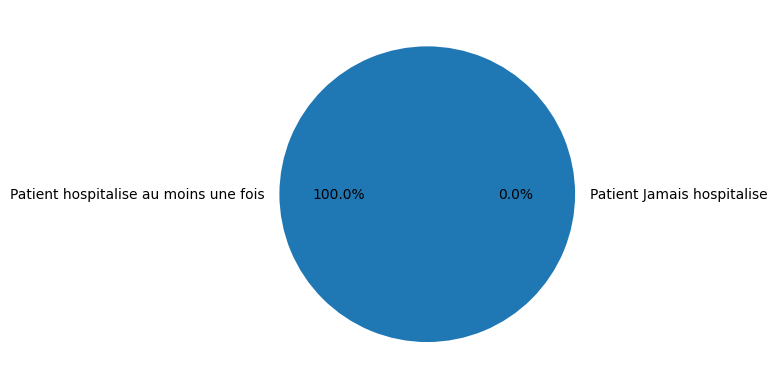

In [43]:
prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct='%1.1f%%');

Ce graph nous montre que dans nos données les personne ayant ete un fois prescrit la medicament 4, 11, 12, 16, 17, 18, son en poly pharmacie et eux tous on deja éte hospitalisé.
Dans un premier temps nous allons essayer d'entrainner notre classifier sur le faible jeu de donnée de 54957, sans les medicaments 4..18, pour voir comment qu'elle seront les alogrithme qui vont separer le plus l'espace des des données et faire les combinaison possible avec ses medicament en poly pour voir le plus nossif

In [49]:
import pyodbc 
# Some other example server values are
# server = 'localhost\sqlexpress' # for a named instance
# server = 'myserver,port' # to specify an alternate port
server = 'JUNIORMSI' 
database = 'Test'  
# ENCRYPT defaults to yes starting in ODBC Driver 18. It's good to always specify ENCRYPT=yes on the client side to avoid MITM attacks.
cnxn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=yes;')
cursor = cnxn.cursor()

In [50]:
drugs = {'Drug_1', 'Drug_4', 'Drug_5', 'Drug_6', 'Drug_7', 'Drug_9', 'Drug_10', 'Drug_11', 'Drug_12',  'Drug_13',  'Drug_15', 'Drug_16', 'Drug_17', 'Drug_18'}
absents_drugs = {'Drug_0', 'Drug_2', 'Drug_3', 'Drug_8', 'Drug_14'}
n_combi = len(drugs)

best_combinaisons = []

while n_combi >= 5:
    print(f'current number of combinaisons: {n_combi}')

    combinaisons = itertools.combinations(drugs, n_combi)

    def combose_query_where(combi, diff):
        query = 'Where'
        for drug in combi:
            query += f' {drug}=1 and'
        
        for drug in diff:
            query += f' {drug}=0 and'
        
        query = query[:-3]

        return query

    best_current_combi = None
    best_score = -np.inf
    for comb in combinaisons:
        combi = set(comb)
        diff = drugs.difference(combi)
        for drug in absents_drugs:
            diff.add(drug)
        query_where = combose_query_where(combi, diff)
        cursor.execute(f"Select hospit From poly_only {query_where}") 
        row = cursor.fetchone()
        y = []
        while row:
            y.append(row[0])
            row = cursor.fetchone()

        y_true = np.int64(y)
        y_pred = np.ones_like(y_true)
        
        score = precision_score(y_true, y_pred)

        if score >= best_score:
            best_score = score
            best_current_combi = combi

    best_combinaisons.append({'combi':best_current_combi, 'score':best_score})

    n_combi -= 1

current number of combinaisons: 14
current number of combinaisons: 13
current number of combinaisons: 12


c:\Users\Auguste Tiemele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


current number of combinaisons: 11
current number of combinaisons: 10


c:\Users\Auguste Tiemele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


current number of combinaisons: 9


c:\Users\Auguste Tiemele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


current number of combinaisons: 8
current number of combinaisons: 7
current number of combinaisons: 6
current number of combinaisons: 5


In [51]:
headers_name = ['patient_id','timestamp','drug_0','drug_1','drug_2','drug_3','drug_4','drug_5','drug_6','drug_7','drug_8','drug_9','drug_10','drug_11','drug_12','drug_13','drug_14','drug_15','drug_16','drug_17','drug_18','hospit','poly']

In [52]:
def tables_by_combi(best_combinaisons):
    combi = best_combinaisons['combi']
    diff = drugs.difference(combi)

    for drug in absents_drugs:
        diff.add(drug)
        
    query_where = combose_query_where(combi, diff)

    cursor.execute(f"Select * From poly_only {query_where}") 
    row = cursor.fetchone()
    tables = []
    while row:
        tables.append(np.array(row))
        row = cursor.fetchone()

    tables = np.array(tables, dtype=np.int64)
    df = pd.DataFrame(tables, columns=headers_name)
    df = df.drop('poly', axis=1)

    return df
    

{'Drug_18', 'Drug_1', 'Drug_13', 'Drug_15', 'Drug_10', 'Drug_7', 'Drug_11', 'Drug_12', 'Drug_17', 'Drug_4', 'Drug_5', 'Drug_16', 'Drug_6', 'Drug_9'}
precission: 0.5


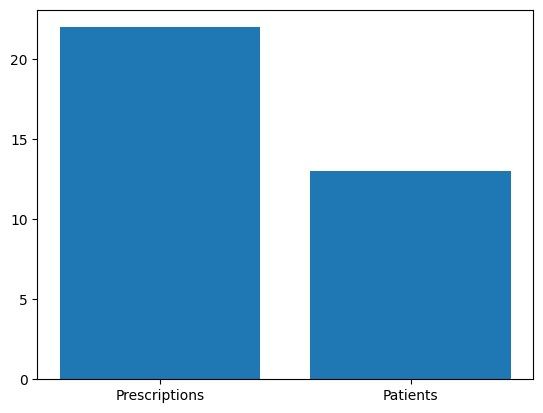

In [53]:
df = tables_by_combi(best_combinaisons[0])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[0]['combi'])
score = best_combinaisons[0]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

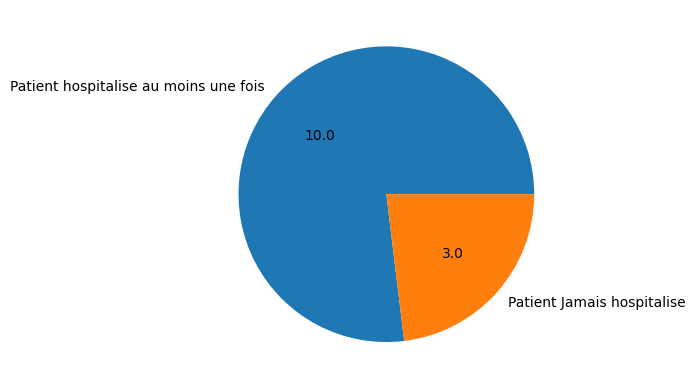

In [54]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_18', 'Drug_1', 'Drug_13', 'Drug_15', 'Drug_10', 'Drug_7', 'Drug_11', 'Drug_12', 'Drug_17', 'Drug_4', 'Drug_5', 'Drug_16', 'Drug_6'}
precission: 0.8


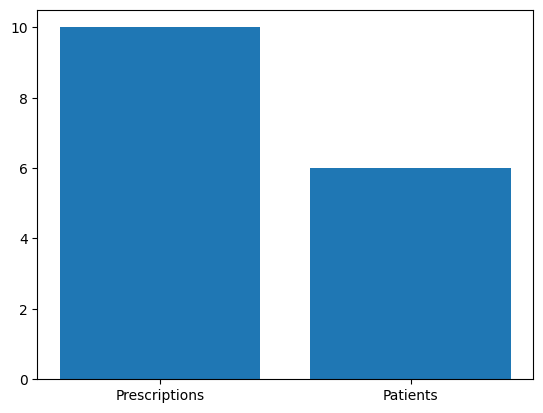

In [55]:
df = tables_by_combi(best_combinaisons[1])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[1]['combi'])
score = best_combinaisons[1]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

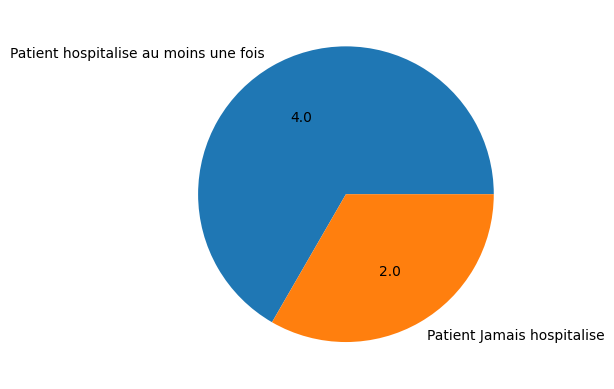

In [56]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_1', 'Drug_15', 'Drug_10', 'Drug_7', 'Drug_11', 'Drug_12', 'Drug_17', 'Drug_4', 'Drug_5', 'Drug_16', 'Drug_6', 'Drug_9'}
precission: 0.8571428571428571


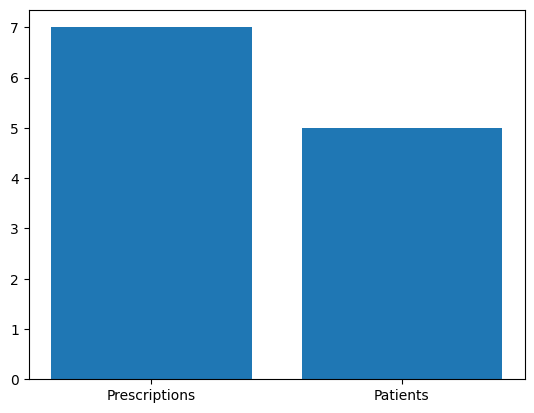

In [57]:
df = tables_by_combi(best_combinaisons[2])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[2]['combi'])
score = best_combinaisons[2]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

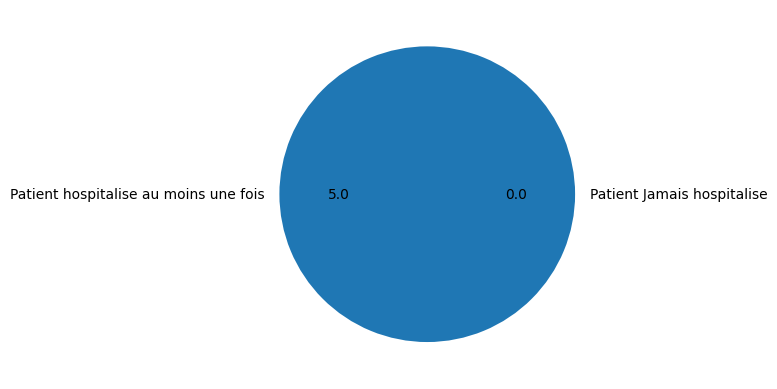

In [58]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_1', 'Drug_13', 'Drug_15', 'Drug_10', 'Drug_11', 'Drug_12', 'Drug_17', 'Drug_4', 'Drug_5', 'Drug_16', 'Drug_6'}
precission: 1.0


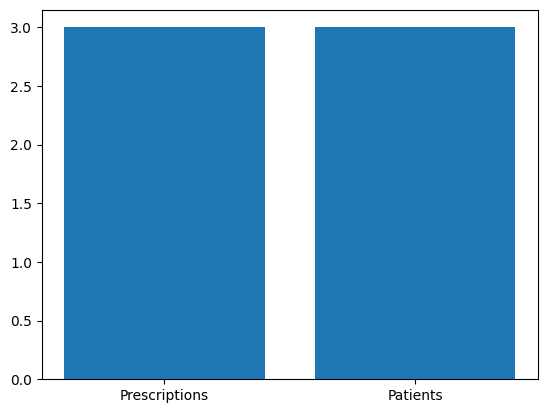

In [59]:
df = tables_by_combi(best_combinaisons[3])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[3]['combi'])
score = best_combinaisons[3]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

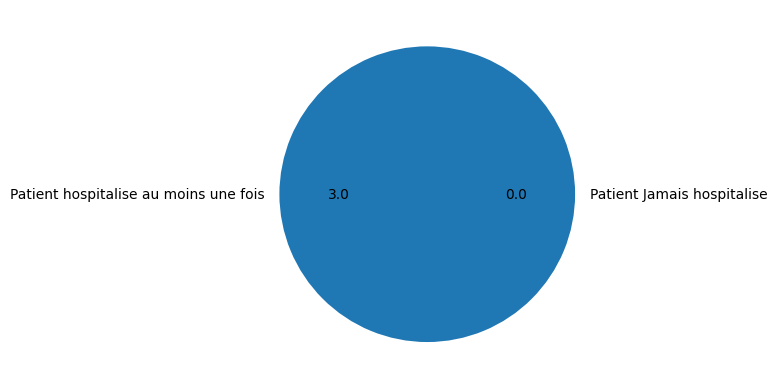

In [60]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_13', 'Drug_15', 'Drug_10', 'Drug_11', 'Drug_12', 'Drug_17', 'Drug_4', 'Drug_5', 'Drug_16', 'Drug_6'}
precission: 1.0


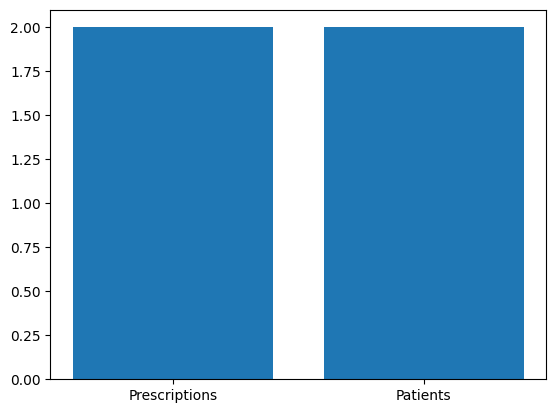

In [61]:
df = tables_by_combi(best_combinaisons[4])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[4]['combi'])
score = best_combinaisons[4]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

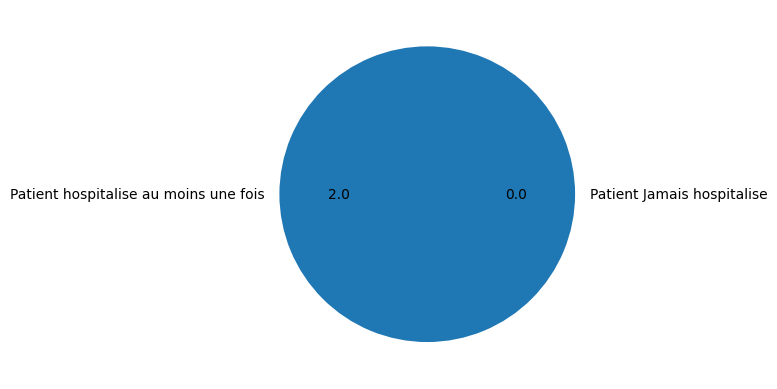

In [62]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_1', 'Drug_10', 'Drug_11', 'Drug_7', 'Drug_17', 'Drug_4', 'Drug_16', 'Drug_6', 'Drug_9'}
precission: 1.0


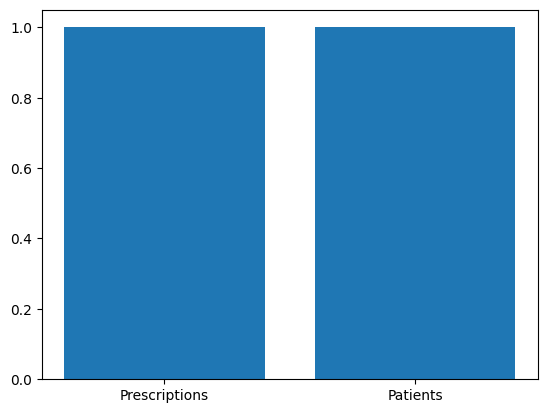

In [63]:
df = tables_by_combi(best_combinaisons[5])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[5]['combi'])
score = best_combinaisons[5]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

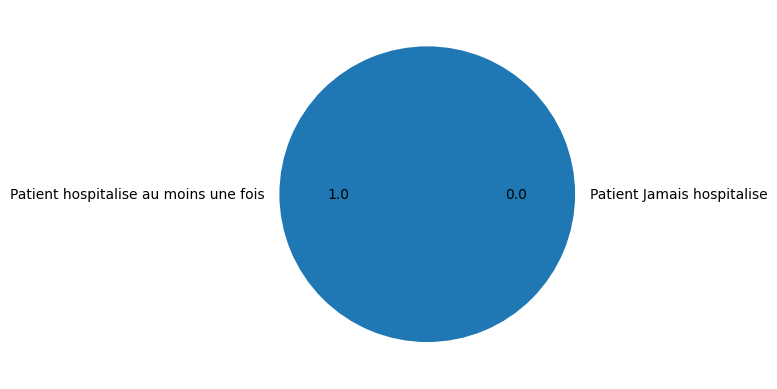

In [64]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_1', 'Drug_15', 'Drug_10', 'Drug_11', 'Drug_17', 'Drug_4', 'Drug_5', 'Drug_16'}
precission: 1.0


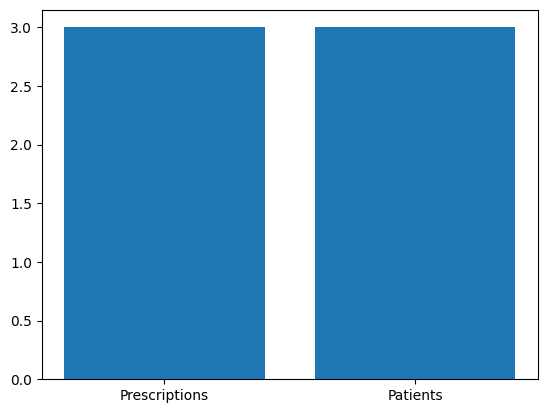

In [65]:
df = tables_by_combi(best_combinaisons[6])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[6]['combi'])
score = best_combinaisons[6]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

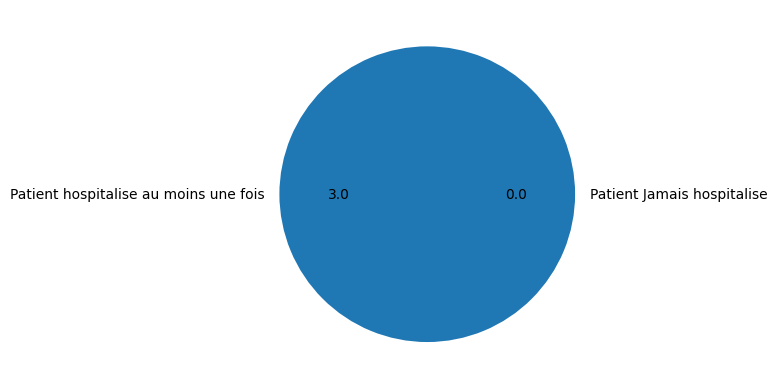

In [66]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_1', 'Drug_13', 'Drug_11', 'Drug_17', 'Drug_4', 'Drug_5', 'Drug_16'}
precission: 0.875


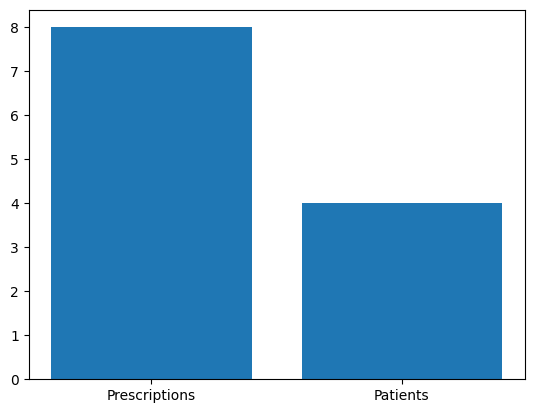

In [67]:
df = tables_by_combi(best_combinaisons[7])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[7]['combi'])
score = best_combinaisons[7]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

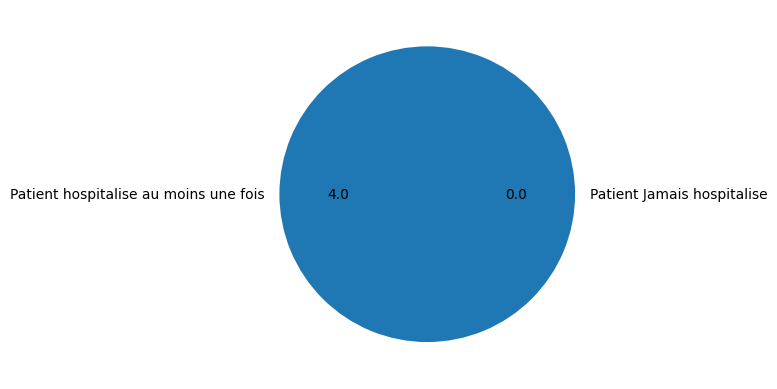

In [68]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_1', 'Drug_13', 'Drug_7', 'Drug_17', 'Drug_4', 'Drug_6'}
precission: 0.8


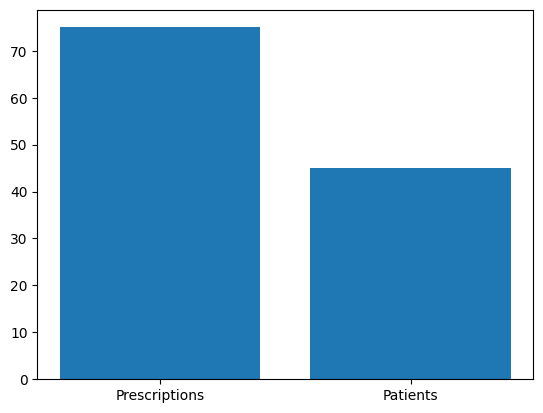

In [69]:
df = tables_by_combi(best_combinaisons[8])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[8]['combi'])
score = best_combinaisons[8]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

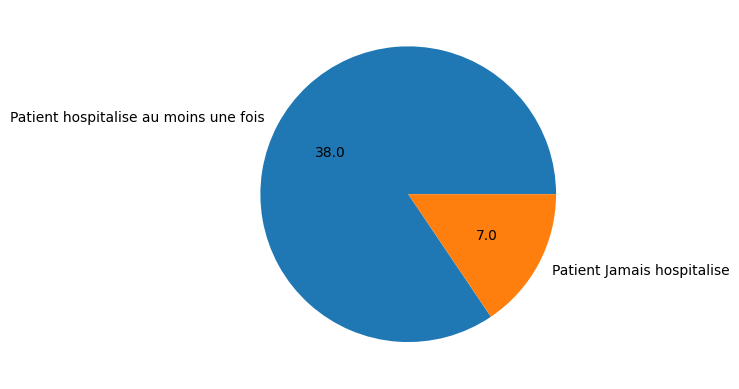

In [70]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=lambda x: np.round(x/100.*sum(prob), 0));

{'Drug_1', 'Drug_13', 'Drug_17', 'Drug_4', 'Drug_6'}
precission: 0.78


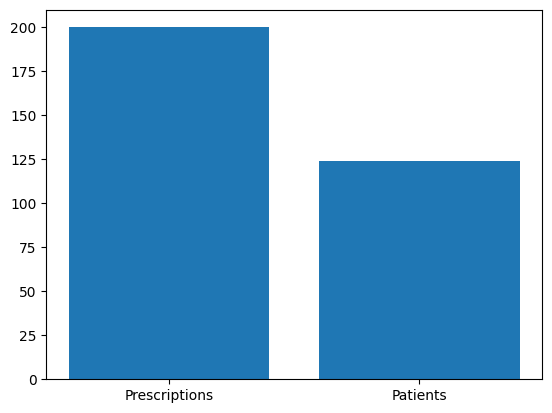

In [96]:
df = tables_by_combi(best_combinaisons[9])
num_observation = df.shape[0]
group_patient = df.groupby('patient_id').sum()
num_patient = group_patient.shape[0]

print(best_combinaisons[9]['combi'])
score = best_combinaisons[9]['score']
print(f'precission: {score}')
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient]);

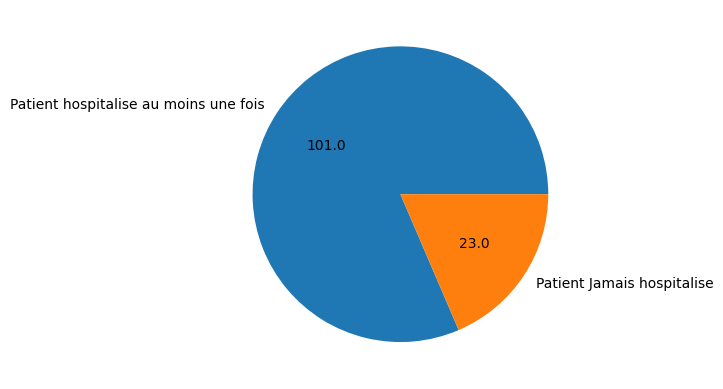

In [97]:
num_patient_hospit = group_patient[group_patient['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient[group_patient['hospit'] == 0].shape[0]

prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalise au moins une fois','Patient Jamais hospitalise'], autopct=%%f%%);

#### Travail sur recuperation des combinaisons avec idée 2

In [72]:
df_method2 = pd.read_csv('data/data_poly_only_method_2.csv', delimiter=';')

num_observation = df_method2.shape[0]
num_hospit = df_method2[df_method2['hospit'] == 1].shape[0]
num_no_hospit = df_method2[df_method2['hospit'] == 0].shape[0]

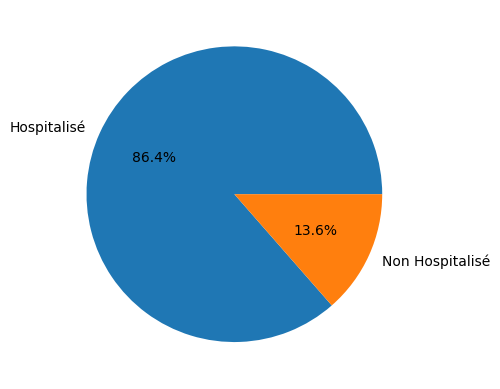

In [73]:
prob = [num_no_hospit, num_hospit]
plt.pie(prob, labels=['Hospitalisé','Non Hospitalisé'], autopct='%1.1f%%');

<BarContainer object of 2 artists>

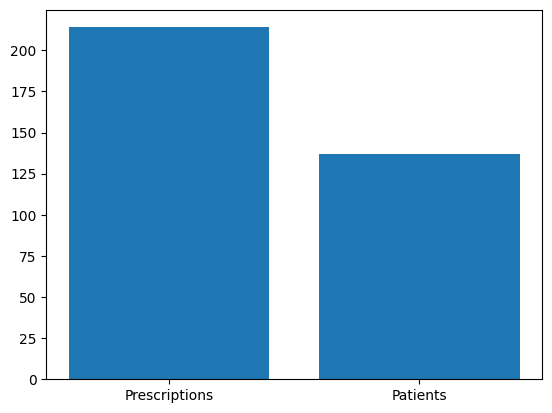

In [74]:
group_patient = df_method2.groupby('patient_id').count()
num_patient = group_patient.shape[0]
plt.bar(['Prescriptions', 'Patients'], height=[num_observation, num_patient])

In [75]:
group_patient_sum = df_method2.groupby('patient_id').sum()
num_patient_hospit = group_patient_sum[group_patient_sum['hospit'] > 0].shape[0]
num_patient_no_hospit = group_patient_sum[group_patient_sum['hospit'] == 0].shape[0]
group_patient_sum.drop(labels=['poly', 'timestamp'], axis=1)

,drug_0,drug_1,drug_2,drug_3,drug_4,drug_5,drug_6,drug_7,drug_8,drug_9,drug_10,drug_11,drug_12,drug_13,drug_14,drug_15,drug_16,drug_17,drug_18,hospit
patient_id,,,,,,,,,,,,,,,,,,,,
8123,2,0,2,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0
8147,2,0,2,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,2
11604,4,0,4,4,0,0,0,0,4,0,0,0,0,0,4,0,0,0,0,0
29940,2,0,2,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0
57736,2,0,2,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850050,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2887480,2,0,2,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0
2911631,4,0,4,4,0,0,0,0,4,0,0,0,0,0,4,0,0,0,0,0


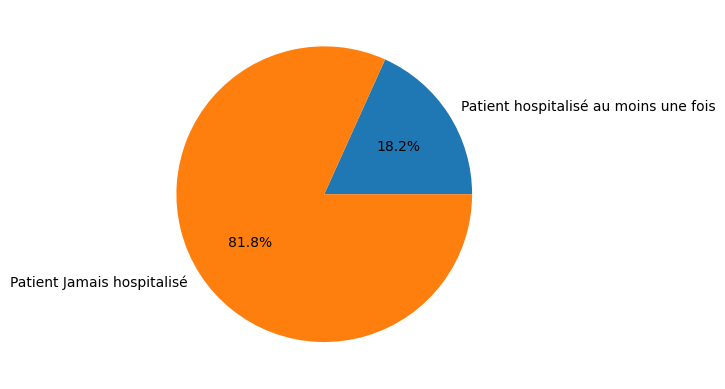

In [76]:
prob = [num_patient_hospit, num_patient_no_hospit]
plt.pie(prob, labels=['Patient hospitalisé au moins une fois','Patient Jamais hospitalisé'], autopct='%1.1f%%');

De facon strategique resoudre notre problement avec cette methode ne semblera pas utile car la proportion de personne jamais hospitallisé est bien trop par rapport a la proportion de personne hospitalisé et de plus nous avons une proportions de personne hospit de 100% avec la methode 1